## Import Module

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats


## Read Data

### Prepare columns of interest and specify their types

In [2]:
# Init constant var to store desired cols and their types
DTYPE_DICT = {
    "user_id": pd.Int64Dtype(),
    "status": pd.StringDtype(),
    "timestamp": pd.Int64Dtype(),
    "data.user_data.meta.is_private": pd.BooleanDtype(),
    "data.user_data.meta.is_verified": pd.BooleanDtype(),
    "data.user_data.meta.is_business_account": pd.BooleanDtype(),
    "data.user_data.meta.is_professional_account": pd.BooleanDtype(),
    "data.user_data.meta.has_reel": pd.BooleanDtype(),
    "data.user_data.meta.total_posts_count": pd.Int64Dtype(),
    "data.user_data.meta.followers_count": pd.Int64Dtype(),
    "data.user_data.meta.followings_count": pd.Int64Dtype(),
}

# Iteratively get the metrics for posts
post_column_pattern = "data.user_data.post.{}.{}"
post_metrics = {
    "is_video": pd.BooleanDtype(),
    "video_view_count": pd.Int64Dtype(),
    "comments_count": pd.Int64Dtype(),
    "comments_disabled": pd.BooleanDtype(),
    "taken_at_timestamp": pd.Int64Dtype(),
    "likes_count": pd.Int64Dtype(),
    "is_pinned": pd.BooleanDtype(),
}

# Populate DTYPE_DICT with desired metrics for 12 posts
for i in range(1, 13):
    for metric, dtype in post_metrics.items():
        column_name = post_column_pattern.format(i, metric)
        DTYPE_DICT[column_name] = dtype

# Iteratively get the metrics for reels
reel_column_pattern = "data.user_data.reel.{}.{}"
reel_metrics = {
    "has_audio": pd.BooleanDtype(),
    "video_view_count": pd.Int64Dtype(),
    "comments_count": pd.Int64Dtype(),
    "comments_disabled": pd.BooleanDtype(),
    "taken_at_timestamp": pd.Int64Dtype(),
    "likes_count": pd.Int64Dtype(),
    "video_duration": pd.Float64Dtype(),
}
        
# Populate DTYPE_DICT with desired metrics for 36 reels
for i in range(1, 37):
    for metric, dtype in reel_metrics.items():
        column_name = reel_column_pattern.format(i, metric)
        DTYPE_DICT[column_name] = dtype

# Get a list of desired columns (for `read_csv()`)
columns_to_read = list(DTYPE_DICT.keys())

In [3]:
data = pd.read_csv(
    ".././data/input/instagram.csv",
    encoding="utf-8",
    index_col=False,
    usecols=columns_to_read,
    dtype=DTYPE_DICT,
)

## Filter Data Based on Account

Filter rows:
1. Failed jobs
2. Account with no reels
3. Private accounts
4. Accounts with total posts < 12
5. Accounts with followers < ? (50 for now)

Remove columns:
1. Post-related columns
2. Account type flags
3. Other irrelevant columns


In [4]:
# Filter out the following rows
data = data.loc[
    (data['status'] == 'successful') &
    (data['data.user_data.meta.has_reel'] == True) &
    (data['data.user_data.meta.is_private'] == False) &
    (data['data.user_data.meta.total_posts_count'] >= 12) &
    (data['data.user_data.meta.followers_count'] > 50)
]

# Filter out columns with names containing "data.user_data.post"
columns_to_drop = [col for col in data.columns if 'data.user_data.post' in col]

# Filter out unary cols
columns_to_drop.extend([
    'status',
    'data.user_data.meta.has_reel',
    'data.user_data.meta.is_private',
])

# Filter out other irrelevant columns
columns_to_drop.extend(
    [
        "data.user_data.meta.is_verified",
        "data.user_data.meta.is_business_account",
        "data.user_data.meta.is_professional_account",
    ]
)

data.drop(columns=columns_to_drop, inplace=True)
data

,user_id,timestamp,data.user_data.meta.total_posts_count,data.user_data.meta.followers_count,data.user_data.meta.followings_count,data.user_data.reel.1.has_audio,data.user_data.reel.1.video_view_count,data.user_data.reel.1.comments_count,data.user_data.reel.1.comments_disabled,data.user_data.reel.1.taken_at_timestamp,...,data.user_data.reel.35.taken_at_timestamp,data.user_data.reel.35.likes_count,data.user_data.reel.35.video_duration,data.user_data.reel.36.has_audio,data.user_data.reel.36.video_view_count,data.user_data.reel.36.comments_count,data.user_data.reel.36.comments_disabled,data.user_data.reel.36.taken_at_timestamp,data.user_data.reel.36.likes_count,data.user_data.reel.36.video_duration
0,1293559,1722469534,1422,2488,2112,True,1051,1,False,1722370215,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,1256735,1722469583,1614,27160,5358,True,2144,1,False,1721673822,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,1334585,1722469667,250,552,278,True,232,0,False,1722373466,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,1104262,1722469699,642,2214,1784,True,1322,0,False,1722407648,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,1206869,1722469734,55,702,1232,True,987,5,False,1720877897,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,1284932,1722570803,135,4996,5258,True,3073,33,False,1710255431,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2744,1331319,1722570821,786,1679,2410,True,109,0,False,1722531756,...,1674162607,37,51.633,True,172,1,False,1673911308,42,61.633
2745,1274132,1722570839,229,1518,2238,True,356,1,False,1717043239,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2747,1333719,1722570885,51,737,765,True,568,4,False,1704155392,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


## Examine data in Account-based Data Frame

### Remove potential influencer accounts

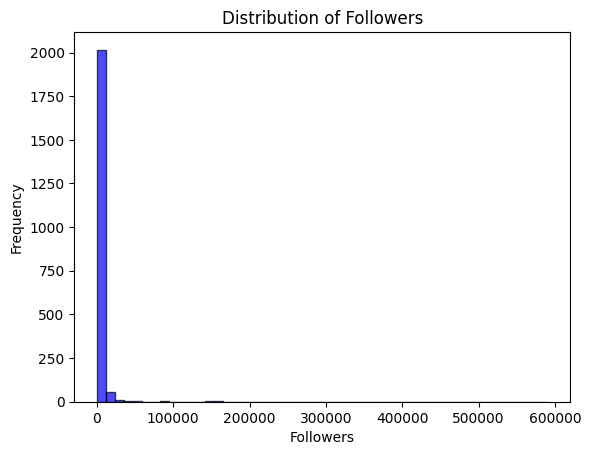

count          2095.0
mean      3060.040095
std      16455.560577
min              56.0
25%             566.0
50%            1056.0
75%            1985.5
max          590805.0
Name: data.user_data.meta.followers_count, dtype: Float64

In [5]:
# Plot distributions in followers
plt.hist(
    data["data.user_data.meta.followers_count"],
    bins=50,
    alpha=0.7,
    color="blue",
    edgecolor="black",
)
plt.xlabel("Followers")
plt.ylabel("Frequency")
plt.title("Distribution of Followers")
plt.show()

data["data.user_data.meta.followers_count"].describe()

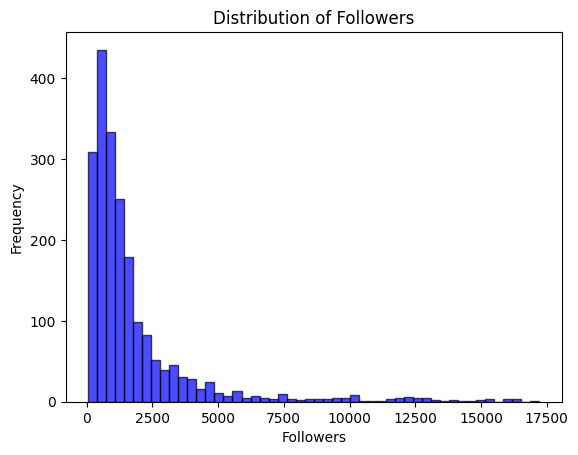

count         2053.0
mean     1765.373113
std      2356.036174
min             56.0
25%            552.0
50%           1032.0
75%           1870.0
max          17212.0
Name: data.user_data.meta.followers_count, dtype: Float64

In [6]:
# Keep only the 98th quantile
data = data[data['data.user_data.meta.followers_count'] <= data['data.user_data.meta.followers_count'].quantile(0.98)]
plt.hist(
    data["data.user_data.meta.followers_count"],
    bins=50,
    alpha=0.7,
    color="blue",
    edgecolor="black",
)
plt.xlabel("Followers")
plt.ylabel("Frequency")
plt.title("Distribution of Followers")
plt.show()

data["data.user_data.meta.followers_count"].describe()

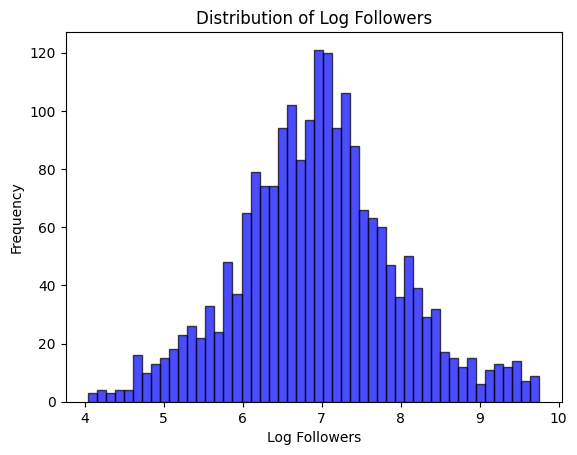

np.float64(0.018063477178461743)

In [7]:
# Log followers
# data["log_followers"] = np.log1p(data["data.user_data.meta.followers_count"])
plt.hist(
    np.log1p(data["data.user_data.meta.followers_count"]),
    bins=50,
    alpha=0.7,
    color="blue",
    edgecolor="black",
)
plt.xlabel("Log Followers")
plt.ylabel("Frequency")
plt.title("Distribution of Log Followers")
plt.show()

stats.normaltest(np.log1p(data["data.user_data.meta.followers_count"])).pvalue # 0.018


### Transform Data

#### Pivot Account-based Data Frame into Reel-based Data Frame

In [8]:
melted = data.melt(
    id_vars=[
        "user_id",
        "timestamp",
        "data.user_data.meta.total_posts_count",
        "data.user_data.meta.followers_count",
        "data.user_data.meta.followings_count",
    ],
    var_name="variable",
    value_name="value",
)
melted[["reel_id", "field"]] = melted["variable"].str.extract(r"reel\.(\d+)\.(.+)")
melted.sort_values(["user_id", "reel_id", "field"])

,user_id,timestamp,data.user_data.meta.total_posts_count,data.user_data.meta.followers_count,data.user_data.meta.followings_count,variable,value,reel_id,field
4348,1018408,1722473971,742,984,643,data.user_data.reel.1.comments_count,0,1,comments_count
6401,1018408,1722473971,742,984,643,data.user_data.reel.1.comments_disabled,False,1,comments_disabled
242,1018408,1722473971,742,984,643,data.user_data.reel.1.has_audio,True,1,has_audio
10507,1018408,1722473971,742,984,643,data.user_data.reel.1.likes_count,6,1,likes_count
8454,1018408,1722473971,742,984,643,data.user_data.reel.1.taken_at_timestamp,1722459602,1,taken_at_timestamp
...,...,...,...,...,...,...,...,...,...
115896,1445323,1722544589,12,522,110,data.user_data.reel.9.has_audio,<NA>,9,has_audio
126161,1445323,1722544589,12,522,110,data.user_data.reel.9.likes_count,<NA>,9,likes_count
124108,1445323,1722544589,12,522,110,data.user_data.reel.9.taken_at_timestamp,<NA>,9,taken_at_timestamp
128214,1445323,1722544589,12,522,110,data.user_data.reel.9.video_duration,<NA>,9,video_duration


In [9]:
# Pivot table
transformed = melted.pivot(
    index=[
        "user_id",
        "reel_id",
        "data.user_data.meta.total_posts_count",
        "data.user_data.meta.followers_count",
        "data.user_data.meta.followings_count",
        "timestamp",
    ],
    columns="field",
    values="value",
).reset_index()

# Reassign reel metrics types
for column, dtype in reel_metrics.items():
    transformed[column] = transformed[column].astype(dtype)
transformed["reel_id"] = transformed["reel_id"].astype(pd.Int64Dtype())

# Rename index and columns
transformed.columns.name = None
transformed = transformed.rename(
    columns={
        "timestamp": "scraped_at",
        "taken_at_timestamp": "created_at",
        "data.user_data.meta.total_posts_count": "total_posts",
        "data.user_data.meta.followers_count": "followers",
        "data.user_data.meta.followings_count": "followings",
    }
)

# Convert epoch timestamp to datetime objects
transformed['created_at_timestamp'] = transformed["created_at"]
transformed['created_at'] = pd.to_datetime(transformed['created_at'], unit='s', utc=True)
transformed['created_at_pst'] = transformed['created_at'].dt.tz_convert('America/Los_Angeles')
transformed['scraped_at_timestamp'] = transformed["scraped_at"]
transformed['scraped_at'] = pd.to_datetime(transformed['scraped_at'], unit='s', utc=True)
transformed['scraped_at_pst'] = transformed['scraped_at'].dt.tz_convert('America/Los_Angeles')

transformed

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,comments_disabled,has_audio,likes_count,created_at,video_duration,video_view_count,created_at_timestamp,created_at_pst,scraped_at_timestamp,scraped_at_pst
0,1018408,1,742,984,643,2024-08-01 00:59:31+00:00,0,False,True,6,2024-07-31 21:00:02+00:00,42.666,137,1722459602,2024-07-31 14:00:02-07:00,1722473971,2024-07-31 17:59:31-07:00
1,1018408,10,742,984,643,2024-08-01 00:59:31+00:00,1,False,True,7,2024-04-09 21:36:44+00:00,91.5,218,1712698604,2024-04-09 14:36:44-07:00,1722473971,2024-07-31 17:59:31-07:00
2,1018408,11,742,984,643,2024-08-01 00:59:31+00:00,0,False,True,10,2024-03-27 21:06:10+00:00,98.0,286,1711573570,2024-03-27 14:06:10-07:00,1722473971,2024-07-31 17:59:31-07:00
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,False,True,6,2024-03-15 21:46:53+00:00,49.0,285,1710539213,2024-03-15 14:46:53-07:00,1722473971,2024-07-31 17:59:31-07:00
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,False,True,6,2024-03-15 21:34:27+00:00,49.012,318,1710538467,2024-03-15 14:34:27-07:00,1722473971,2024-07-31 17:59:31-07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73903,1445323,5,12,522,110,2024-08-01 20:36:29+00:00,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,NaT,1722544589,2024-08-01 13:36:29-07:00
73904,1445323,6,12,522,110,2024-08-01 20:36:29+00:00,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,NaT,1722544589,2024-08-01 13:36:29-07:00
73905,1445323,7,12,522,110,2024-08-01 20:36:29+00:00,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,NaT,1722544589,2024-08-01 13:36:29-07:00
73906,1445323,8,12,522,110,2024-08-01 20:36:29+00:00,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,NaT,1722544589,2024-08-01 13:36:29-07:00


## Summarize cleaned data set

In [10]:
def summarize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    summary = []
    for col in df.columns:
        column_data = df[col]
        col_summary = {
            "Column": col,
            "Data Type": column_data.dtype,
            "NA %": column_data.isna().mean() * 100,
            "Unique Values": column_data.nunique(),
            "Mean": column_data.mean() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Median": column_data.median() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Min": column_data.min() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Max": column_data.max() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Range": (column_data.max() - column_data.min()) if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Top Frequency": column_data.value_counts().iloc[0] if not column_data.isna().all() else None,
        }
        
        # Handle boolean columns
        if column_data.dtype in [pd.BooleanDtype(), bool]:
            true_count = column_data.sum()
            false_count = len(column_data) - column_data.isna().sum() - true_count
            col_summary["True Count"] = true_count
            col_summary["False Count"] = false_count
            col_summary["True %"] = (true_count / (true_count + false_count)) * 100
            col_summary["False %"] = (false_count / (true_count + false_count)) * 100
        summary.append(col_summary)

    return pd.DataFrame(summary)

# Get summary
summarize_dataframe(transformed)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2053,1.216978e+06,1.225752e+06,1.018408e+06,1.445323e+06,4.269150e+05,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.850000e+01,1.850000e+01,1.000000e+00,3.600000e+01,3.500000e+01,2053,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1003,5.582884e+02,3.650000e+02,1.200000e+01,3.075500e+04,3.074300e+04,324,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1466,1.765373e+03,1.032000e+03,5.600000e+01,1.721200e+04,1.715600e+04,252,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1403,1.268748e+03,9.070000e+02,0.000000e+00,7.535000e+03,7.535000e+03,216,NaN,NaN,NaN,NaN
5,scraped_at,"datetime64[s, UTC]",0.000000,2030,NaN,NaN,NaN,NaN,NaN,72,NaN,NaN,NaN,NaN
6,comments_count,Int64,33.602587,154,3.028773e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,23175,NaN,NaN,NaN,NaN
7,comments_disabled,boolean,33.602587,2,NaN,NaN,NaN,NaN,NaN,49068,5.0,49068.0,0.010189,99.989811
8,has_audio,boolean,33.602587,2,NaN,NaN,NaN,NaN,NaN,45774,45774.0,3299.0,93.277362,6.722638
9,likes_count,Int64,33.602587,573,4.896729e+01,1.600000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3039,NaN,NaN,NaN,NaN


## Filter reels
1. Unknown posting time
2. Comments disabled
3. Video duration < 1 seconds or > 90 seconds (Instagram Reels typically have a max duration of 90 seconds)

In [11]:
# Drop rows with N/A created_at timestamp
cleaned = transformed.dropna(subset=["created_at"])

# Drop rows with comment disabled and remove this unary column
cleaned = cleaned[cleaned["comments_disabled"] == False].drop(columns=["comments_disabled"])

# Drop rows with video duration < 1 or is NA or is > 90 seconds
cleaned = cleaned[(cleaned["video_duration"].between(1, 90, inclusive="both")) & (cleaned["video_duration"]).notna()]

# Preview
summarize_dataframe(cleaned)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2046,1.216378e+06,1.224059e+06,1.018408e+06,1.445323e+06,426915.0,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.353854e+01,1.300000e+01,1.000000e+00,3.600000e+01,35.0,1713,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1003,6.610070e+02,4.540000e+02,1.200000e+01,3.075500e+04,30743.0,180,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1464,1.971000e+03,1.169000e+03,5.600000e+01,1.721200e+04,17156.0,144,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1400,1.388954e+03,1.012500e+03,0.000000e+00,7.535000e+03,7535.0,129,NaN,NaN,NaN,NaN
5,scraped_at,"datetime64[s, UTC]",0.000000,2023,NaN,NaN,NaN,NaN,NaN,64,NaN,NaN,NaN,NaN
6,comments_count,Int64,0.000000,148,3.175768e+00,1.000000e+00,0.000000e+00,2.863000e+03,2863.0,18622,NaN,NaN,NaN,NaN
7,has_audio,boolean,0.000000,2,NaN,NaN,NaN,NaN,NaN,36005,36005.0,3257.0,91.704447,8.295553
8,likes_count,Int64,0.000000,538,5.344807e+01,1.600000e+01,0.000000e+00,3.362760e+05,336276.0,2668,NaN,NaN,NaN,NaN
9,created_at,"datetime64[s, UTC]",0.000000,38143,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN


## Prepare columns

### 1. Time elapsed from posted time to scraped time (in seconds)

In [12]:
augmented = cleaned.copy()

# Free useless dfs from memory
# del data, melted, transformed, cleaned
# import gc; gc.collect()

# Calculate the time difference between scraped_at and created_at
augmented["time_elapsed"] = augmented["scraped_at"] - augmented["created_at"]
augmented

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,has_audio,likes_count,created_at,video_duration,video_view_count,created_at_timestamp,created_at_pst,scraped_at_timestamp,scraped_at_pst,time_elapsed
0,1018408,1,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-07-31 21:00:02+00:00,42.666,137,1722459602,2024-07-31 14:00:02-07:00,1722473971,2024-07-31 17:59:31-07:00,0 days 03:59:29
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:46:53+00:00,49.0,285,1710539213,2024-03-15 14:46:53-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:12:38
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:34:27+00:00,49.012,318,1710538467,2024-03-15 14:34:27-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:25:04
5,1018408,14,742,984,643,2024-08-01 00:59:31+00:00,0,True,7,2024-03-14 19:57:06+00:00,49.0,411,1710446226,2024-03-14 12:57:06-07:00,1722473971,2024-07-31 17:59:31-07:00,139 days 05:02:25
7,1018408,16,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2023-11-23 20:00:40+00:00,49.012,415,1700769640,2023-11-23 12:00:40-08:00,1722473971,2024-07-31 17:59:31-07:00,251 days 04:58:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73870,1444154,8,692,509,486,2024-08-01 20:26:53+00:00,0,True,2,2024-01-20 03:43:11+00:00,3.925,263,1705722191,2024-01-19 19:43:11-08:00,1722544013,2024-08-01 13:26:53-07:00,194 days 16:43:42
73871,1444154,9,692,509,486,2024-08-01 20:26:53+00:00,0,True,1,2024-01-18 02:54:49+00:00,47.999,200,1705546489,2024-01-17 18:54:49-08:00,1722544013,2024-08-01 13:26:53-07:00,196 days 17:32:04
73872,1445323,1,12,522,110,2024-08-01 20:36:29+00:00,0,True,10,2023-10-31 21:53:09+00:00,79.8,167,1698789189,2023-10-31 14:53:09-07:00,1722544589,2024-08-01 13:36:29-07:00,274 days 22:43:20
73883,1445323,2,12,522,110,2024-08-01 20:36:29+00:00,1,True,33,2021-08-11 00:11:37+00:00,22.133,<NA>,1628640697,2021-08-10 17:11:37-07:00,1722544589,2024-08-01 13:36:29-07:00,1086 days 20:24:52


Plot and see the distribution of time elapsed

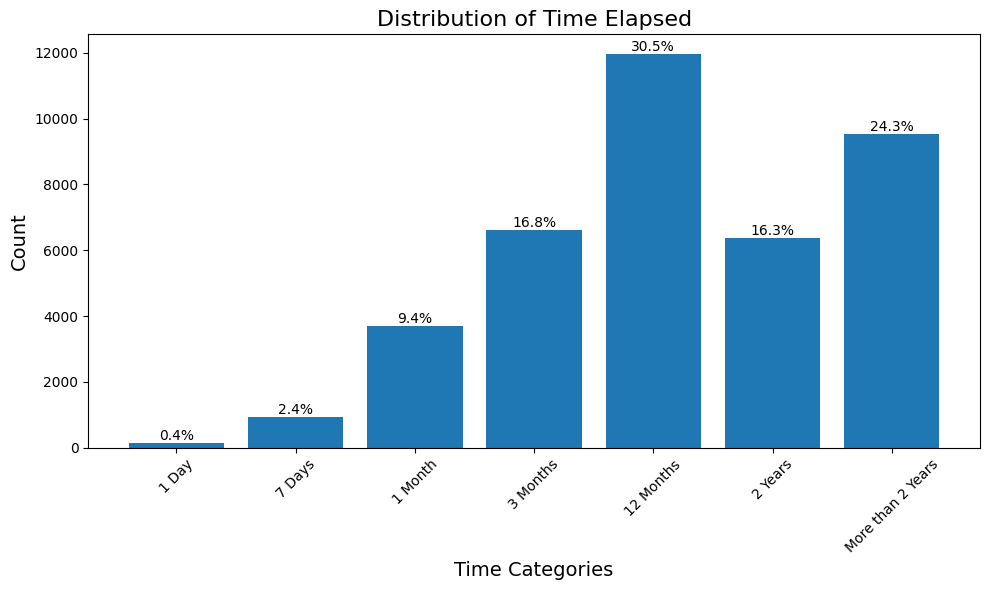

In [13]:
# Define the bin edges (in days) and labels
bins = [
    0, 
    1,             # 1 Day
    7,             # 7 Days
    30,            # 1 Month
    90,            # 3 Months
    365,           # 12 Months
    730,           # 2 Years
    float('inf')   # More than 2 Years
]
labels = [
    '1 Day', '7 Days', '1 Month', '3 Months', '12 Months', '2 Years', 'More than 2 Years',
]

# Create a new column for bins
augmented['time_elapsed_category'] = pd.cut(augmented['time_elapsed'].dt.days, bins=bins, labels=labels, right=False)

# Calculate distribution and percentages
distribution = augmented['time_elapsed_category'].value_counts().sort_index()
percentages = (distribution / len(augmented)) * 100

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(distribution.index.astype(str), distribution.values)

# Add percentage labels to each bar
for bar, percent in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{percent:.1f}%", ha='center', va='bottom')

# Customize plot
ax.set_title("Distribution of Time Elapsed", fontsize=16)
ax.set_xlabel("Time Categories", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
augmented

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,has_audio,likes_count,created_at,video_duration,video_view_count,created_at_timestamp,created_at_pst,scraped_at_timestamp,scraped_at_pst,time_elapsed,time_elapsed_category
0,1018408,1,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-07-31 21:00:02+00:00,42.666,137,1722459602,2024-07-31 14:00:02-07:00,1722473971,2024-07-31 17:59:31-07:00,0 days 03:59:29,1 Day
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:46:53+00:00,49.0,285,1710539213,2024-03-15 14:46:53-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:12:38,12 Months
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:34:27+00:00,49.012,318,1710538467,2024-03-15 14:34:27-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:25:04,12 Months
5,1018408,14,742,984,643,2024-08-01 00:59:31+00:00,0,True,7,2024-03-14 19:57:06+00:00,49.0,411,1710446226,2024-03-14 12:57:06-07:00,1722473971,2024-07-31 17:59:31-07:00,139 days 05:02:25,12 Months
7,1018408,16,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2023-11-23 20:00:40+00:00,49.012,415,1700769640,2023-11-23 12:00:40-08:00,1722473971,2024-07-31 17:59:31-07:00,251 days 04:58:51,12 Months
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73870,1444154,8,692,509,486,2024-08-01 20:26:53+00:00,0,True,2,2024-01-20 03:43:11+00:00,3.925,263,1705722191,2024-01-19 19:43:11-08:00,1722544013,2024-08-01 13:26:53-07:00,194 days 16:43:42,12 Months
73871,1444154,9,692,509,486,2024-08-01 20:26:53+00:00,0,True,1,2024-01-18 02:54:49+00:00,47.999,200,1705546489,2024-01-17 18:54:49-08:00,1722544013,2024-08-01 13:26:53-07:00,196 days 17:32:04,12 Months
73872,1445323,1,12,522,110,2024-08-01 20:36:29+00:00,0,True,10,2023-10-31 21:53:09+00:00,79.8,167,1698789189,2023-10-31 14:53:09-07:00,1722544589,2024-08-01 13:36:29-07:00,274 days 22:43:20,12 Months
73883,1445323,2,12,522,110,2024-08-01 20:36:29+00:00,1,True,33,2021-08-11 00:11:37+00:00,22.133,<NA>,1628640697,2021-08-10 17:11:37-07:00,1722544589,2024-08-01 13:36:29-07:00,1086 days 20:24:52,More than 2 Years


Take out reels that are less than 7 days old

We assume that reels after 7 days are receiving negligible amount of engagement, and those within posted 7 days (from the time the data was collected) are still receiving some. Since these reels consist of less than 3% of the total data, we decide to remove them.

A side note: is it more rational to make the engagement metric relative to the time elaspsed? For example, there's some scalar to be applied to reels posted within 1 day to predict what it would be like in the next week? Maybe not worth the time for just 3% of the data.

In [15]:
augmented = augmented[augmented['time_elapsed'] >= pd.Timedelta(days=7)]
# augmented.drop(columns=['time_elapsed_category'], inplace=True)  # Remove intermediate column
summarize_dataframe(augmented)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2045,1.216474e+06,1.224059e+06,1.018408e+06,1.445323e+06,426915.0,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.385477e+01,1.300000e+01,1.000000e+00,3.600000e+01,35.0,1615,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1003,6.528384e+02,4.510000e+02,1.200000e+01,3.075500e+04,30743.0,177,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1463,1.955131e+03,1.167000e+03,5.600000e+01,1.721200e+04,17156.0,140,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1400,1.386367e+03,1.013000e+03,0.000000e+00,7.535000e+03,7535.0,129,NaN,NaN,NaN,NaN
5,scraped_at,"datetime64[s, UTC]",0.000000,2022,NaN,NaN,NaN,NaN,NaN,61,NaN,NaN,NaN,NaN
6,comments_count,Int64,0.000000,148,3.221270e+00,1.000000e+00,0.000000e+00,2.863000e+03,2863.0,17911,NaN,NaN,NaN,NaN
7,has_audio,boolean,0.000000,2,NaN,NaN,NaN,NaN,NaN,34998,34998.0,3168.0,91.699418,8.300582
8,likes_count,Int64,0.000000,537,5.447718e+01,1.600000e+01,0.000000e+00,3.362760e+05,336276.0,2569,NaN,NaN,NaN,NaN
9,created_at,"datetime64[s, UTC]",0.000000,37087,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN


### 2. Categorize created_at into weekday

In [16]:
# Create day_of_week column (Monday=1, ..., Sunday=7) and converted to Int64Dtype
augmented = augmented.copy()
augmented['day_of_week_pst'] = augmented['created_at_pst'].dt.dayofweek + 1  # Adjust from 0-6 to 1-7
augmented['day_of_week_pst'] = augmented['day_of_week_pst'].astype(pd.Int64Dtype())

# Use cut to categorize time in PST
# Morning (4, 11]: 05:00 to 11:59
# Afternoon (11, 16]: 12:00 to 16:59
# Evening (16, 11]: 17:00 to 23:59
# Night (-1, 4]: 00:00 AM to 04:59
augmented['categorized_created_at_pst'] = pd.cut(
    augmented['created_at_pst'].dt.hour,
    bins=[-1, 4, 11, 16, 23],
    labels=['Night', 'Morning', 'Afternoon', 'Evening']
)

augmented

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,has_audio,likes_count,created_at,video_duration,video_view_count,created_at_timestamp,created_at_pst,scraped_at_timestamp,scraped_at_pst,time_elapsed,time_elapsed_category,day_of_week_pst,categorized_created_at_pst
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:46:53+00:00,49.0,285,1710539213,2024-03-15 14:46:53-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:12:38,12 Months,5,Afternoon
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2024-03-15 21:34:27+00:00,49.012,318,1710538467,2024-03-15 14:34:27-07:00,1722473971,2024-07-31 17:59:31-07:00,138 days 03:25:04,12 Months,5,Afternoon
5,1018408,14,742,984,643,2024-08-01 00:59:31+00:00,0,True,7,2024-03-14 19:57:06+00:00,49.0,411,1710446226,2024-03-14 12:57:06-07:00,1722473971,2024-07-31 17:59:31-07:00,139 days 05:02:25,12 Months,4,Afternoon
7,1018408,16,742,984,643,2024-08-01 00:59:31+00:00,0,True,6,2023-11-23 20:00:40+00:00,49.012,415,1700769640,2023-11-23 12:00:40-08:00,1722473971,2024-07-31 17:59:31-07:00,251 days 04:58:51,12 Months,4,Afternoon
9,1018408,18,742,984,643,2024-08-01 00:59:31+00:00,0,True,16,2023-10-20 20:18:28+00:00,69.44,641,1697833108,2023-10-20 13:18:28-07:00,1722473971,2024-07-31 17:59:31-07:00,285 days 04:41:03,12 Months,5,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73870,1444154,8,692,509,486,2024-08-01 20:26:53+00:00,0,True,2,2024-01-20 03:43:11+00:00,3.925,263,1705722191,2024-01-19 19:43:11-08:00,1722544013,2024-08-01 13:26:53-07:00,194 days 16:43:42,12 Months,5,Evening
73871,1444154,9,692,509,486,2024-08-01 20:26:53+00:00,0,True,1,2024-01-18 02:54:49+00:00,47.999,200,1705546489,2024-01-17 18:54:49-08:00,1722544013,2024-08-01 13:26:53-07:00,196 days 17:32:04,12 Months,3,Evening
73872,1445323,1,12,522,110,2024-08-01 20:36:29+00:00,0,True,10,2023-10-31 21:53:09+00:00,79.8,167,1698789189,2023-10-31 14:53:09-07:00,1722544589,2024-08-01 13:36:29-07:00,274 days 22:43:20,12 Months,2,Afternoon
73883,1445323,2,12,522,110,2024-08-01 20:36:29+00:00,1,True,33,2021-08-11 00:11:37+00:00,22.133,<NA>,1628640697,2021-08-10 17:11:37-07:00,1722544589,2024-08-01 13:36:29-07:00,1086 days 20:24:52,More than 2 Years,2,Evening


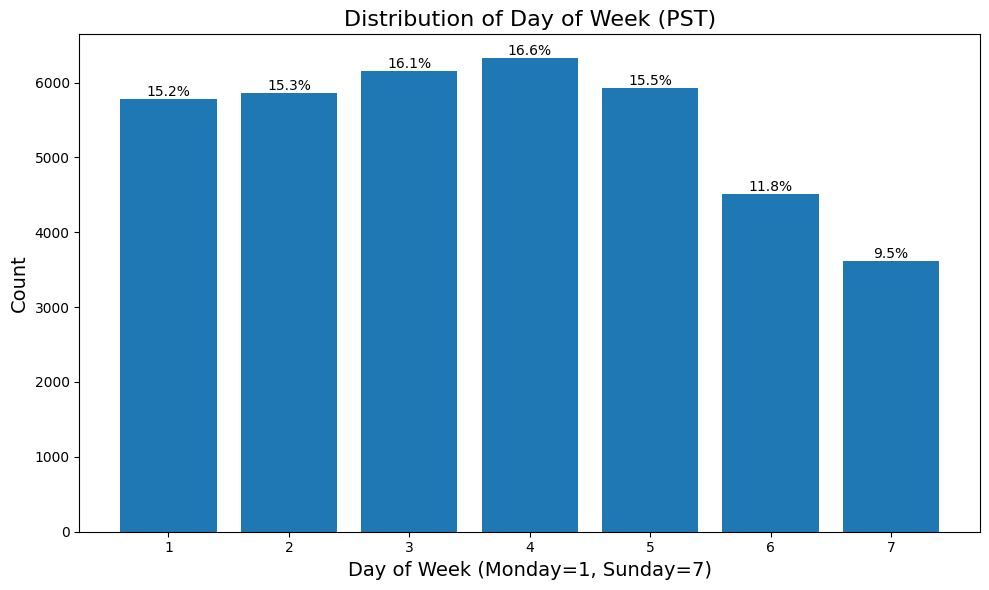

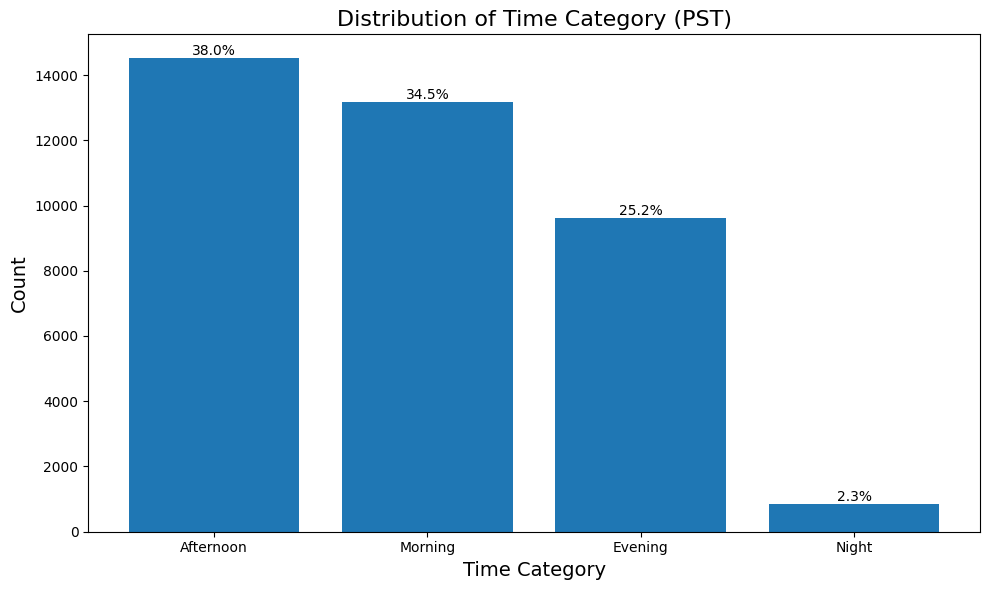

In [17]:
# Plot distribution of `day_of_week_pst`
day_of_week_counts = augmented['day_of_week_pst'].value_counts().sort_index()
day_of_week_percentages = (day_of_week_counts / len(augmented)) * 100

fig, ax1 = plt.subplots(figsize=(10, 6))
bars = ax1.bar(day_of_week_counts.index, day_of_week_counts.values, tick_label=day_of_week_counts.index)

for bar, percent in zip(bars, day_of_week_percentages):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percent:.1f}%", 
             ha='center', va='bottom')

ax1.set_title("Distribution of Day of Week (PST)", fontsize=16)
ax1.set_xlabel("Day of Week (Monday=1, Sunday=7)", fontsize=14)
ax1.set_ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()

# Plot distribution of `time_category_pst`
time_category_counts = augmented['categorized_created_at_pst'].value_counts()
time_category_percentages = (time_category_counts / len(augmented)) * 100

fig, ax2 = plt.subplots(figsize=(10, 6))
bars = ax2.bar(time_category_counts.index, time_category_counts.values, 
               tick_label=time_category_counts.index)

for bar, percent in zip(bars, time_category_percentages):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percent:.1f}%", 
             ha='center', va='bottom')

ax2.set_title("Distribution of Time Category (PST)", fontsize=16)
ax2.set_xlabel("Time Category", fontsize=14)
ax2.set_ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()


/tmp/ipykernel_2536/1944535520.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  augmented = augmented.replace('Night', 'Evening')


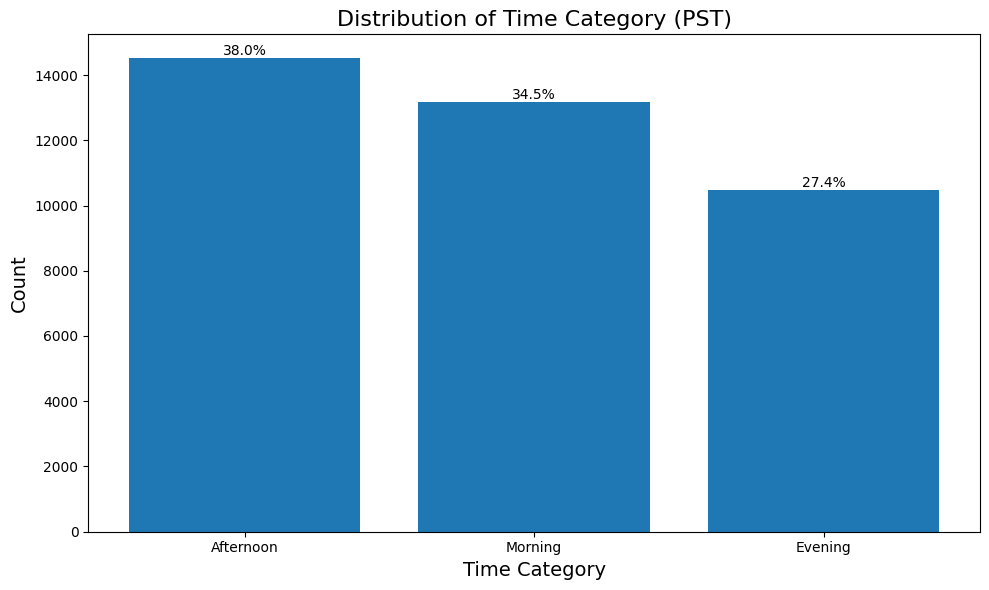

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2045,1.216474e+06,1.224059e+06,1.018408e+06,1.445323e+06,426915.0,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.385477e+01,1.300000e+01,1.000000e+00,3.600000e+01,35.0,1615,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1003,6.528384e+02,4.510000e+02,1.200000e+01,3.075500e+04,30743.0,177,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1463,1.955131e+03,1.167000e+03,5.600000e+01,1.721200e+04,17156.0,140,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1400,1.386367e+03,1.013000e+03,0.000000e+00,7.535000e+03,7535.0,129,NaN,NaN,NaN,NaN
5,scraped_at,"datetime64[s, UTC]",0.000000,2022,NaN,NaN,NaN,NaN,NaN,61,NaN,NaN,NaN,NaN
6,comments_count,Int64,0.000000,148,3.221270e+00,1.000000e+00,0.000000e+00,2.863000e+03,2863.0,17911,NaN,NaN,NaN,NaN
7,has_audio,boolean,0.000000,2,NaN,NaN,NaN,NaN,NaN,34998,34998.0,3168.0,91.699418,8.300582
8,likes_count,Int64,0.000000,537,5.447718e+01,1.600000e+01,0.000000e+00,3.362760e+05,336276.0,2569,NaN,NaN,NaN,NaN
9,created_at,"datetime64[s, UTC]",0.000000,37087,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN


In [18]:
# Since Night category has only 2.2% records, we combine Evening and Night into Evening category (standing for the time after normal office hours)
augmented = augmented.replace('Night', 'Evening')

# Plot distribution of `time_category_pst`
time_category_counts = augmented['categorized_created_at_pst'].value_counts()
time_category_percentages = (time_category_counts / len(augmented)) * 100

fig, ax2 = plt.subplots(figsize=(10, 6))
bars = ax2.bar(time_category_counts.index, time_category_counts.values, 
               tick_label=time_category_counts.index)

for bar, percent in zip(bars, time_category_percentages):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percent:.1f}%", 
             ha='center', va='bottom')

ax2.set_title("Distribution of Time Category (PST)", fontsize=16)
ax2.set_xlabel("Time Category", fontsize=14)
ax2.set_ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()

summarize_dataframe(augmented)

## Handle NAs


Impute NAs in has_audio as True?
`cleaned_data["has_audio"] = cleaned_data["has_audio"].fillna(True)`

Impute NAs in video_view_count with the average ratio of video_view_count to like_count?


In [19]:
# Compare engagement metrics between videos with and without view counts
augmented.groupby(augmented['video_view_count'].isna())[["likes_count", "comments_count", "video_duration"]].describe()

# No obvious systematic differences in critical engagement metrics

likes_count                                                 \
                       count       mean          std  min   25%   50%   75%   
video_view_count                                                              
False                32192.0  58.828746  2120.191658  0.0   6.0  15.0  34.0   
True                  5974.0  31.027954    37.110385  0.0  10.0  20.0  39.0   

                           comments_count            ...               \
                       max          count      mean  ...  75%     max   
video_view_count                                     ...                
False             336276.0        32192.0  3.359126  ...  3.0  2863.0   
True                 786.0         5974.0  2.478406  ...  3.0   170.0   

                 video_duration                                              \
                          count       mean        std  min      25%     50%   
video_view_count                                                              
False                   32192.0  37.132652   24.83936  1.0     15.0    31.1   
True                     5974.0  31.113224  22.599388  1.0  11.1225  24.633   

                                    
                       75%     max  
video_view_count                    
False               58.747    90.0  
True              55.51625  89.966  

[2 rows x 24 columns]

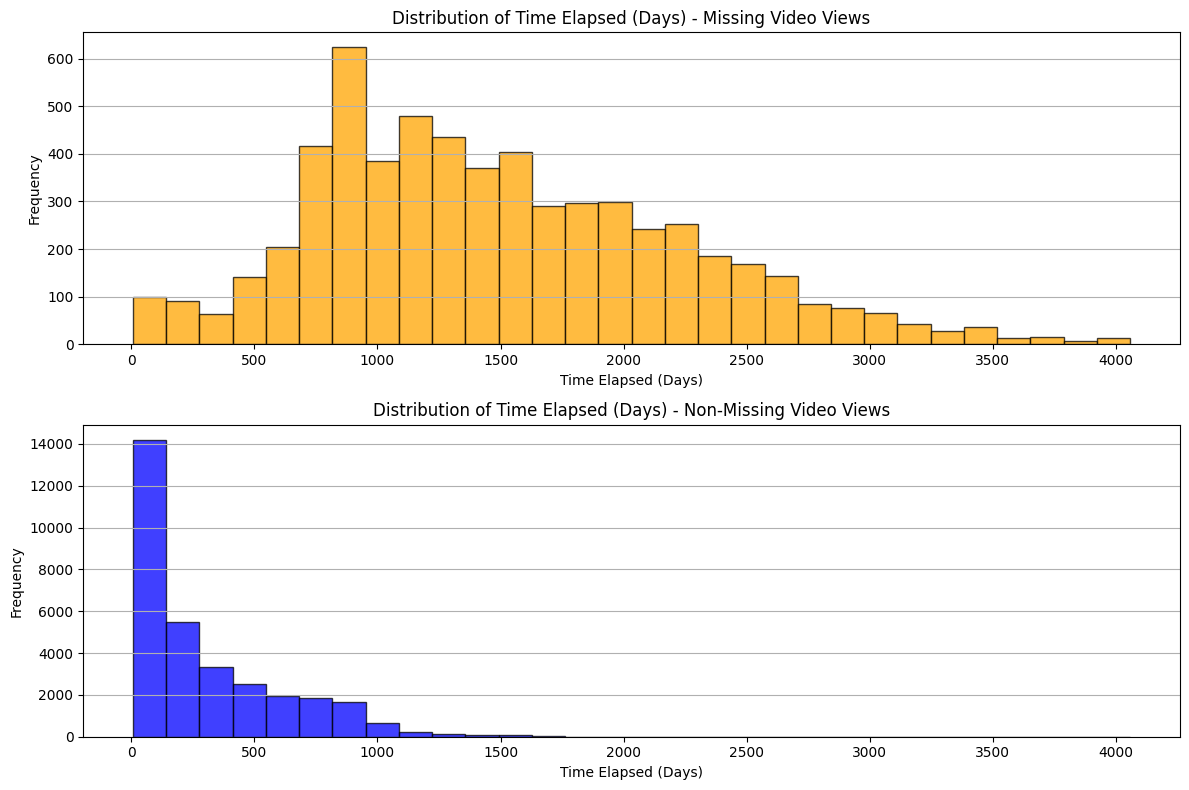

In [20]:
# Define common bin edges for the histos
bin_edges = np.histogram_bin_edges(
    pd.concat([augmented[augmented['video_view_count'].isna()]['time_elapsed'].dt.days, augmented[~augmented['video_view_count'].isna()]['time_elapsed'].dt.days]),
    bins=30
)

# Create figure
plt.figure(figsize=(12, 8))

# Plot histogram for missing `video_view_count`
plt.subplot(2, 1, 1)
plt.hist(
    augmented[augmented['video_view_count'].isna()]['time_elapsed'].dt.days, 
    bins=bin_edges, 
    alpha=0.75, 
    color='orange', 
    edgecolor='black'
)
plt.title('Distribution of Time Elapsed (Days) - Missing Video Views')
plt.xlabel('Time Elapsed (Days)')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Plot histogram for non-missing `video_view_count`
plt.subplot(2, 1, 2)
plt.hist(
    augmented[~augmented['video_view_count'].isna()]['time_elapsed'].dt.days, 
    bins=bin_edges,
    alpha=0.75,
    color='blue',
    edgecolor='black',
)
plt.title('Distribution of Time Elapsed (Days) - Non-Missing Video Views')
plt.xlabel('Time Elapsed (Days)')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Adjust layout
plt.tight_layout()
plt.show()

# Seems that the missingness was not random. It's more likely for an older reel to miss view counts. Maybe apply RF for imputation or just drop it (15% is a lot but it saves time and we still have about 40k rows).

### Impute NAs in video views
#### Preprocessing data

In [21]:
# Preprocess data
# Get time elasped in seconds
augmented["time_elapsed_seconds"] = augmented["time_elapsed"].dt.total_seconds()

# Encode has_audio
augmented["has_audio"] = augmented["has_audio"].astype(pd.Int64Dtype())

# One-Hot Encode 'day_of_week_pst' and 'categorized_created_at_pst'
day_of_week_dummies = pd.get_dummies(
    augmented["day_of_week_pst"],
    prefix="day",
    drop_first=True,  # Use Monday as reference
).astype(pd.Int64Dtype())
time_category_dummies = pd.get_dummies(
    augmented["categorized_created_at_pst"],
    prefix="time_cat",
    drop_first=True,  # Use Evening as reference
).astype(pd.Int64Dtype())

# Concatenate the dummy variables to the dataframe
augmented = pd.concat([augmented, day_of_week_dummies, time_category_dummies], axis=1)

# Define features selected
X_COLS = [
    "total_posts",
    "followers",
    "followings",
    # "comments_count",  # Removed due to the multicollinearity issue with likes_count
    "has_audio",  # Encoded into binary 0 or 1
    "likes_count",  # .9 correlation with views; assuming no data leakage;
    "video_duration",
    "time_elapsed_seconds",
    # "day_of_week_pst",  # One-hot encoded
    # "categorized_created_at_pst",  # One-hot encoded
] + list(day_of_week_dummies.columns) + list(time_category_dummies.columns)
Y_COL = "video_view_count"

# del day_of_week_dummies, time_category_dummies; gc.collect()

train_data = augmented[augmented["video_view_count"].notna()].copy()
missing_data = augmented[augmented["video_view_count"].isna()].copy()
train_data

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,has_audio,likes_count,created_at,...,categorized_created_at_pst,time_elapsed_seconds,day_2,day_3,day_4,day_5,day_6,day_7,time_cat_Afternoon,time_cat_Evening
3,1018408,12,742,984,643,2024-08-01 00:59:31+00:00,0,1,6,2024-03-15 21:46:53+00:00,...,Afternoon,11934758.0,0,0,0,1,0,0,1,0
4,1018408,13,742,984,643,2024-08-01 00:59:31+00:00,0,1,6,2024-03-15 21:34:27+00:00,...,Afternoon,11935504.0,0,0,0,1,0,0,1,0
5,1018408,14,742,984,643,2024-08-01 00:59:31+00:00,0,1,7,2024-03-14 19:57:06+00:00,...,Afternoon,12027745.0,0,0,1,0,0,0,1,0
7,1018408,16,742,984,643,2024-08-01 00:59:31+00:00,0,1,6,2023-11-23 20:00:40+00:00,...,Afternoon,21704331.0,0,0,1,0,0,0,1,0
9,1018408,18,742,984,643,2024-08-01 00:59:31+00:00,0,1,16,2023-10-20 20:18:28+00:00,...,Afternoon,24640863.0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73868,1444154,6,692,509,486,2024-08-01 20:26:53+00:00,0,1,3,2024-01-20 22:30:58+00:00,...,Afternoon,16754155.0,0,0,0,0,1,0,1,0
73869,1444154,7,692,509,486,2024-08-01 20:26:53+00:00,0,1,4,2024-01-20 17:59:59+00:00,...,Morning,16770414.0,0,0,0,0,1,0,0,0
73870,1444154,8,692,509,486,2024-08-01 20:26:53+00:00,0,1,2,2024-01-20 03:43:11+00:00,...,Evening,16821822.0,0,0,0,1,0,0,0,1
73871,1444154,9,692,509,486,2024-08-01 20:26:53+00:00,0,1,1,2024-01-18 02:54:49+00:00,...,Evening,16997524.0,0,1,0,0,0,0,0,1


#### Examine distributions

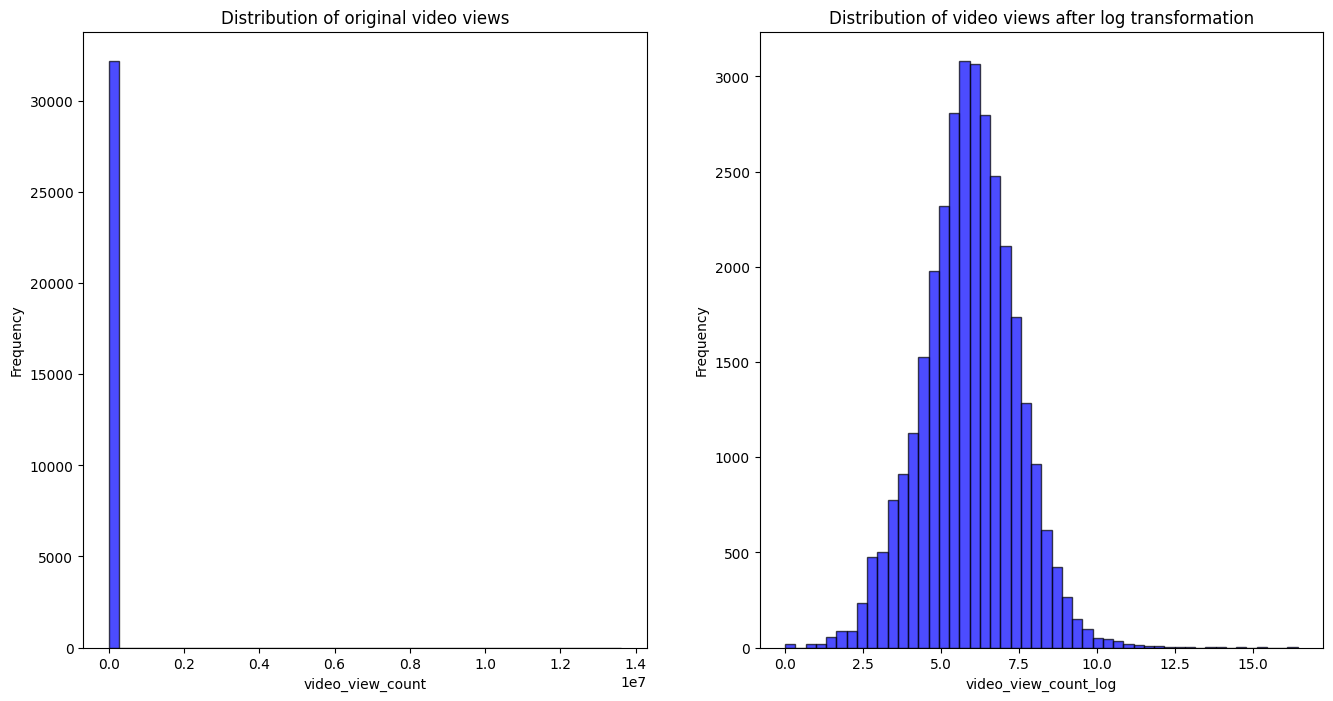

In [22]:
# Plot distribution
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.hist(train_data[Y_COL], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of original video views')
plt.xlabel('video_view_count')
plt.ylabel('Frequency')
# plt.show()

# Highly skewed to the right
train_data['video_view_count_log'] = np.log1p(train_data[Y_COL])  # Get log(1+x) as view can be 0
Y_COL_TRANSFORMED = 'video_view_count_log'

# Plot again, satisfied
plt.subplot(1, 2, 2)
plt.hist(train_data[Y_COL_TRANSFORMED], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of video views after log transformation')
plt.xlabel('video_view_count_log')
plt.ylabel('Frequency')
plt.show()

#### Examine correlation

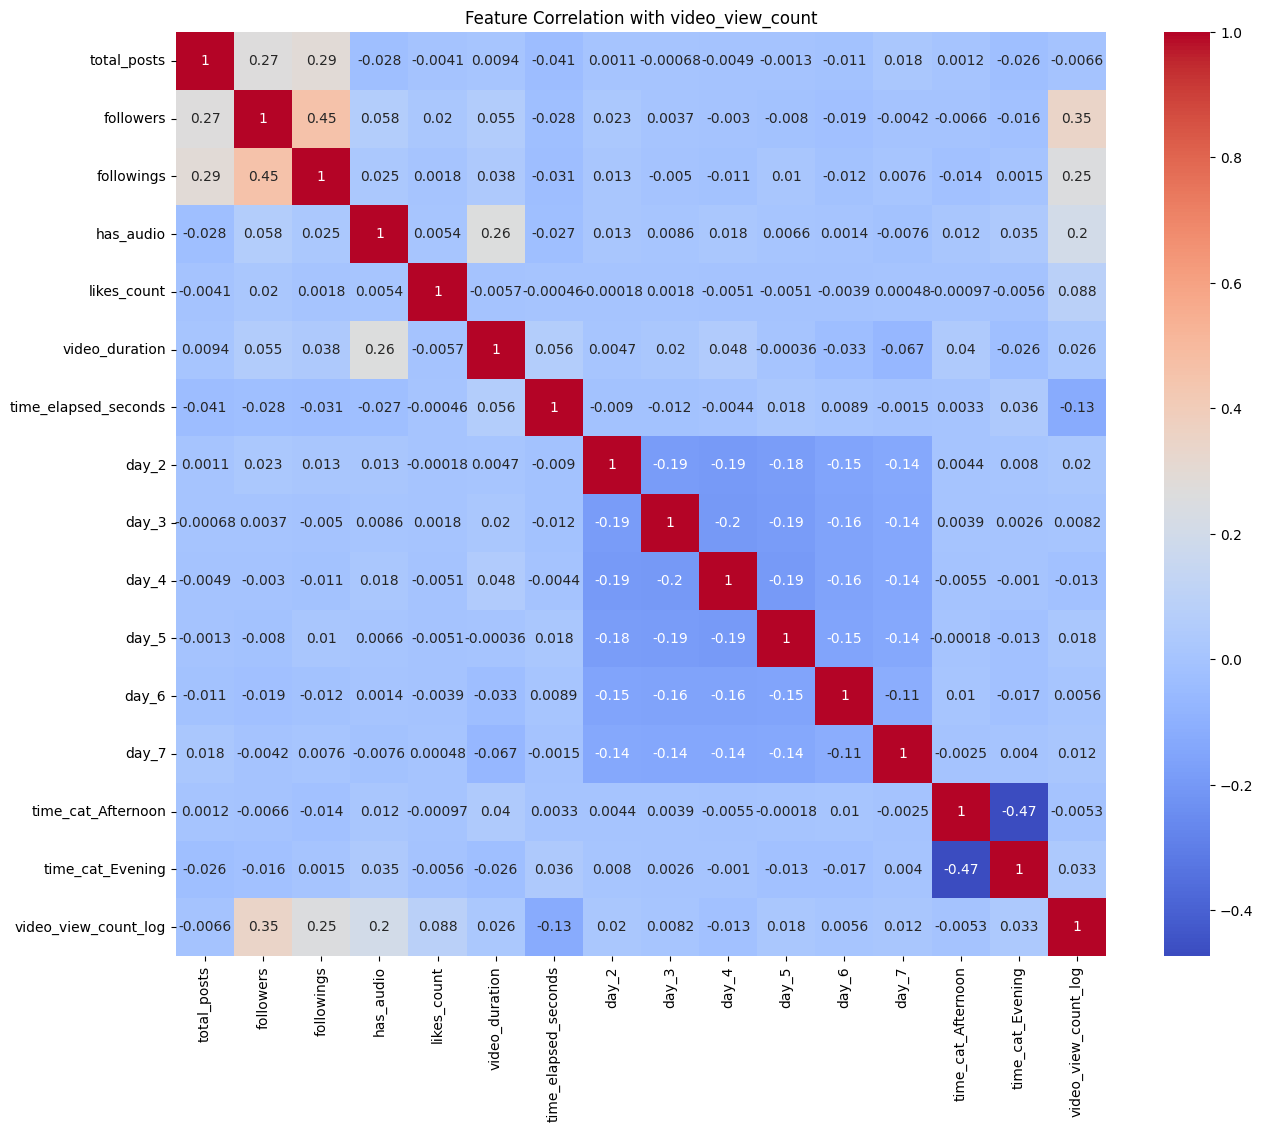

In [23]:
import seaborn as sns
corr_matrix = train_data[X_COLS + [Y_COL_TRANSFORMED]].corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation with video_view_count")
plt.show()

# High positive correlation found in likes_count and comments_count (0.73); Dropping comments_count;

# Medium positive correlation found in followers and followings is fine.

# Medium negative correlation found in time_cat (around -0.50) is normal due to the nature of one-hot encoding.
# It's not a concern in RF. But in case other models (e.g., linear regression), it might introduce multicollinearty issues.
# So we drop the first categories in time_cat (and day_of_week, because why not) to reduce potential multicollinearity.

#### Fit a Random Forest

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Define features and target
X = train_data[X_COLS]
y = train_data[Y_COL_TRANSFORMED]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

# Used hyperparameters tuned by Grid and Randomized CV Search
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42,  # Make reproducible
)
rf.fit(X_train, y_train)  # Takes about 1 minutes?
rf.score(X_valid, y_valid)  # R-squared Score: 0.8134437488337324


0.8134437488337324

#### (Optional) Tuning Hyperparameters
Run with caution!! Takes about 9 minutes to search.

In [248]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for tuning
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5],
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
)
grid_search_rf.fit(X_train, y_train)
print(f'Grid Best Random Forest parameters: {grid_search_rf.best_params_}')
print("="*33)
# Grid Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

# Try also RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42,
)
random_search_rf.fit(X_train, y_train)
print(f'Randomized Best Random Forest parameters: {random_search_rf.best_params_}')
# Randomized Best Random Forest parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  10.8s
[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  11.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  13.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  13.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.5s
[CV] END ma

/home/mirrienl/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  10.9s
[CV] END max_depth=None, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  11.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  13.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estim

#### Model Evaluation and Validation

Suppose that the random forest is the best model. We place the imputed values back to `augmented`.

In [25]:
# Generate predictions on missing data
imputed_log_views = rf.predict(missing_data[X_COLS])

# Convert the logged views back
imputed_values = np.expm1(imputed_log_views).round().astype(int)  # Since we used p1, we use m1 here
imputed = augmented.copy()
imputed["is_view_count_imputed"] = imputed[Y_COL].isna().astype(pd.Int64Dtype())
imputed.loc[augmented[Y_COL].isna(), Y_COL] = imputed_values
summarize_dataframe(imputed)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency
0,user_id,Int64,0.0,2045,1.216474e+06,1.224059e+06,1.018408e+06,1.445323e+06,426915.0,36
1,reel_id,Int64,0.0,36,1.385477e+01,1.300000e+01,1.000000e+00,3.600000e+01,35.0,1615
2,total_posts,Int64,0.0,1003,6.528384e+02,4.510000e+02,1.200000e+01,3.075500e+04,30743.0,177
3,followers,Int64,0.0,1463,1.955131e+03,1.167000e+03,5.600000e+01,1.721200e+04,17156.0,140
4,followings,Int64,0.0,1400,1.386367e+03,1.013000e+03,0.000000e+00,7.535000e+03,7535.0,129
5,scraped_at,"datetime64[s, UTC]",0.0,2022,NaN,NaN,NaN,NaN,NaN,61
6,comments_count,Int64,0.0,148,3.221270e+00,1.000000e+00,0.000000e+00,2.863000e+03,2863.0,17911
7,has_audio,Int64,0.0,2,9.169942e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.0,34998
8,likes_count,Int64,0.0,537,5.447718e+01,1.600000e+01,0.000000e+00,3.362760e+05,336276.0,2569
9,created_at,"datetime64[s, UTC]",0.0,37087,NaN,NaN,NaN,NaN,NaN,3


#### Residual Analysis

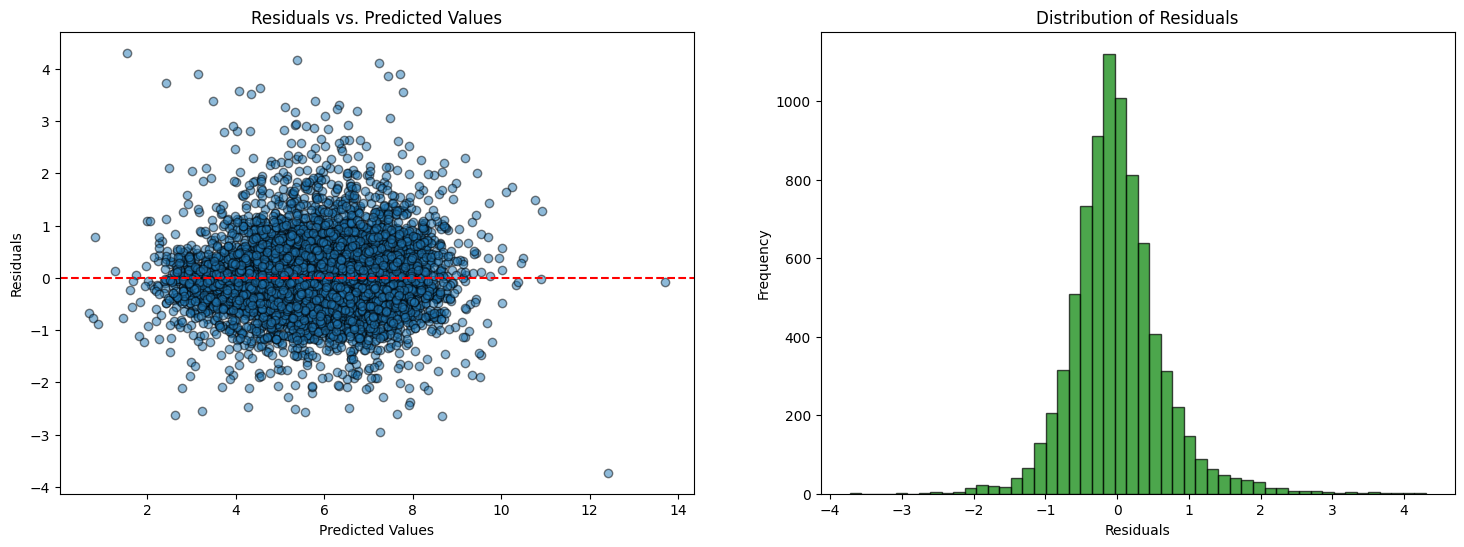

In [26]:
# Calculate residuals
residuals = y_valid - rf.predict(X_valid)

# Scatter plot of residuals vs. predicted values
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.scatter(rf.predict(X_valid), residuals, alpha=0.5, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')

# Distribution of residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# The RF model appears well fitted, with residuals having no clear pattern, supporting the linearity and equal-variance assumption.

4.267720428836231e-66


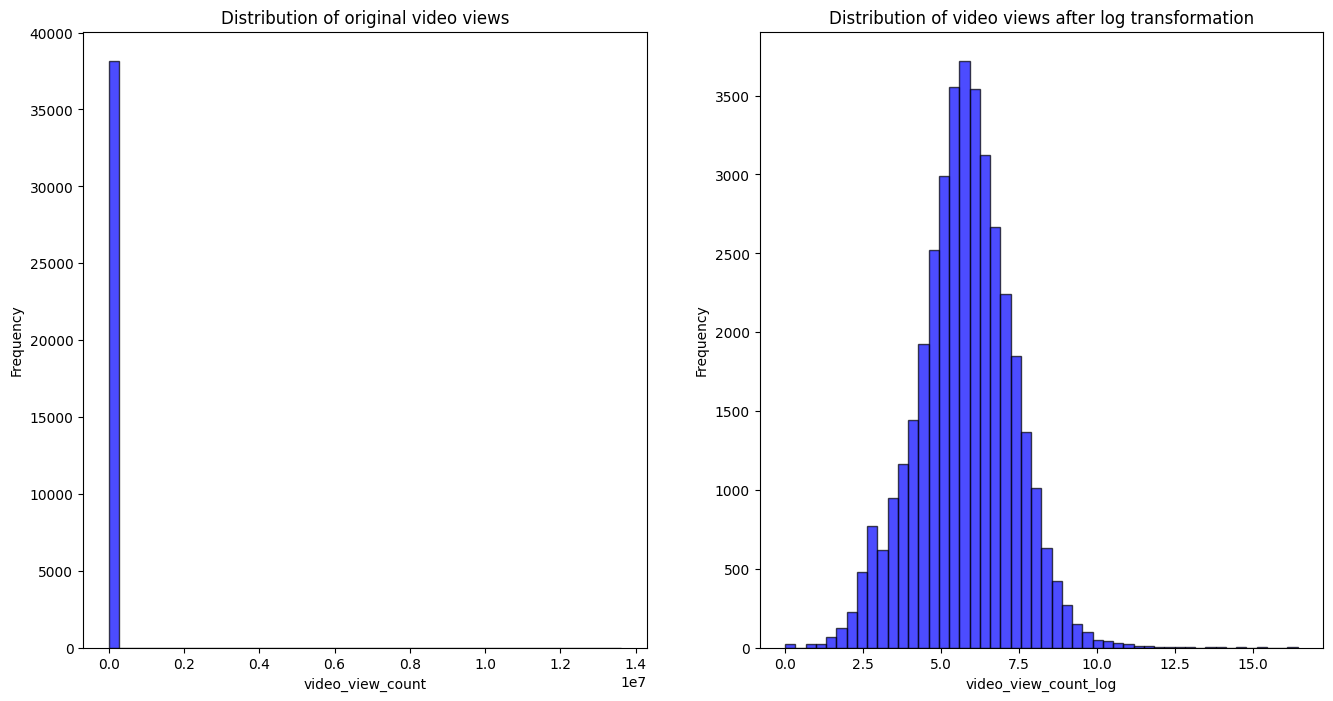

In [27]:
# stats.normaltest(imputed["video_view_count"])
# imputed["video_view_count"].describe()

# Print the top 10% of the video counts
# np.log1p(imputed['video_view_count']).sort_values(ascending=False)

print(stats.normaltest(np.log1p(imputed['video_view_count'])).pvalue)

# Plot distribution
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.hist(imputed['video_view_count'], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of original video views')
plt.xlabel('video_view_count')
plt.ylabel('Frequency')
# plt.show()

# Highly skewed to the right
train_data['video_view_count_log'] = np.log1p(train_data[Y_COL])  # Get log(1+x) as view can be 0
Y_COL_TRANSFORMED = 'video_view_count_log'

# Plot again, satisfied
plt.subplot(1, 2, 2)
plt.hist(np.log1p(imputed['video_view_count']), bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of video views after log transformation')
plt.xlabel('video_view_count_log')
plt.ylabel('Frequency')
plt.show()

## Handle Outliers

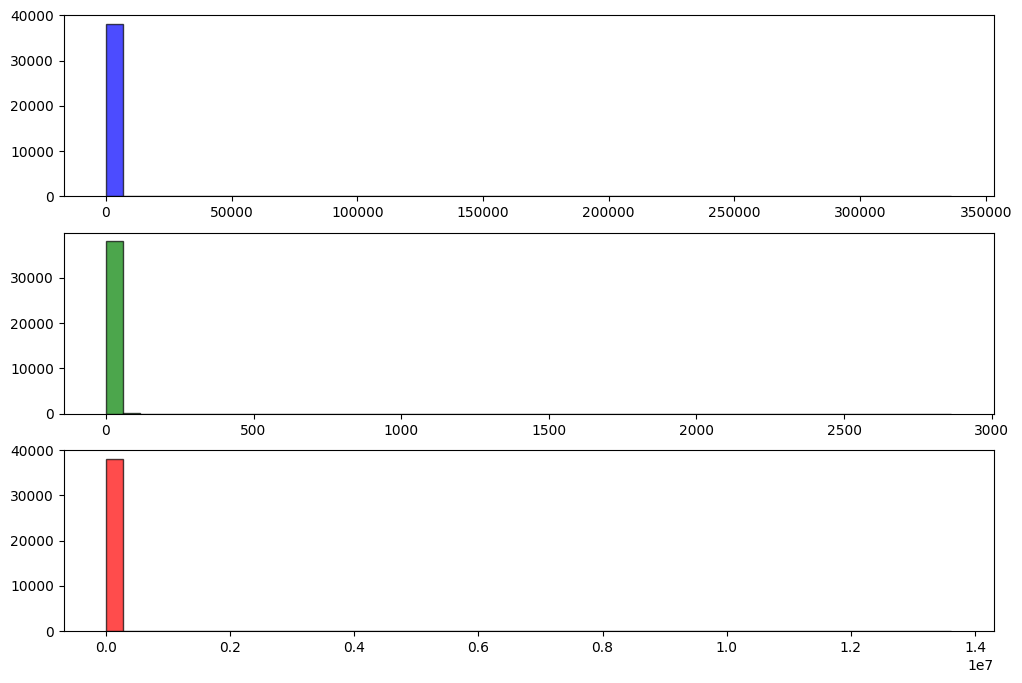

,likes_count,comments_count,video_view_count
count,38166.0,38166.0,38166.0
mean,54.477179,3.22127,1694.797333
std,1947.277786,25.681207,75137.504419
min,0.0,0.0,0.0
25%,6.0,0.0,125.0
50%,16.0,1.0,321.0
75%,35.0,3.0,837.0
max,336276.0,2863.0,13618871.0


In [28]:
# Plot distributions of engagement metrics
plt.figure(figsize=(12, 8))

# 1. Likes
plt.subplot(3, 1, 1)
plt.hist(
    imputed["likes_count"],
    bins=50,
    alpha=0.7,
    color="blue",
    edgecolor="black",
    label="Likes",
)

# 2. Comments
plt.subplot(3, 1, 2)
plt.hist(
    imputed["comments_count"],
    bins=50,
    alpha=0.7,
    color="green",
    edgecolor="black",
    label="Comments",
)

# 3. Views
plt.subplot(3, 1, 3)
plt.hist(
    imputed["video_view_count"],
    bins=50,
    alpha=0.7,
    color="red",
    edgecolor="black",
    label="Views",
)

plt.show()

imputed[["likes_count", "comments_count", "video_view_count",]].describe()

### Try DBSCAN

In [ ]:
# Free memory
del (
    augmented,
    cleaned,
    data,
    # day_of_week_dummies,
    day_of_week_counts,
    imputed_log_views,
    imputed_values,
    residuals,
    # time_category_dummies,
    train_data,
    transformed,
    X,
    X_train,
    X_valid,
    y,
    y_train,
    y_valid,
    melted,
    missing_data,
)
import gc

gc.collect()

35929

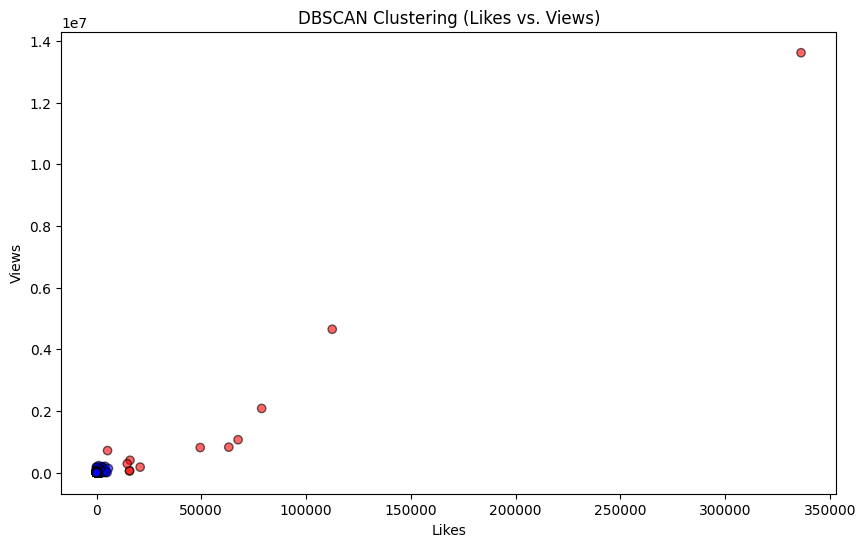

In [30]:
# Try removing reels that faked likes or comments
imputed_2 = imputed.copy()

# Try DBSCAN Clustering to find outliers
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import numpy as np

# eps_values = np.linspace(0.5, 3.0, 6)  # 0.5 to 3.0, step 0.5
# min_samples_values = range(2, 11)       # 2 to 10

# # Initialize variables to store the best parameters and score
# best_eps = None
# best_min_samples = None
# best_score = -np.inf  # Start with a very low score

# scaled_data = StandardScaler().fit_transform(imputed_2[['followers', 'likes_count', 'comments_count', 'video_view_count']])

# for eps in eps_values:
#     for min_samples in min_samples_values:
#         print(f"Trying eps={eps}, min_samples={min_samples}")
#         # Fit DBSCAN
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         labels = dbscan.fit_predict(scaled_data)

#         # Ignore models that classify all points as noise
#         if len(set(labels)) <= 1:  # Only one cluster or all noise
#             continue

#         # Evaluate the clustering
#         try:
#             # Use Silhouette Score or Calinski-Harabasz Index
#             score = silhouette_score(scaled_data, labels)
#             # score = calinski_harabasz_score(scaled_data, labels)  # Optional
#         except ValueError:  # Handle edge cases (e.g., single cluster)
#             continue

#         print(f"Silhouette Score: {score}")

#         # Update best parameters if the score is improved
#         if score > best_score:
#             best_score = score
#             best_eps = eps
#             best_min_samples = min_samples

# # Print best parameters
# print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best score: {best_score}")

# Found eps = 3, min_samples = 3, score = 0.98

# Make and fit pipeline
model = make_pipeline(
    StandardScaler(),
    DBSCAN(eps=3, min_samples=3),
)

# Extract labels
imputed_2['labels'] = model.fit_predict(imputed_2[['followers', 'likes_count', 'comments_count', 'video_view_count']])

# Print outliers
outliers = imputed_2[imputed_2['labels'] == -1]
# print(outliers)

# visualize outliers
plt.figure(figsize=(10, 6))
colors = ['red' if label == -1 else 'blue' for label in imputed_2['labels']]
plt.scatter(imputed_2['likes_count'], imputed_2['video_view_count'], c=colors, alpha=0.6, edgecolors='k')
plt.title('DBSCAN Clustering (Likes vs. Views)')
plt.xlabel('Likes')
plt.ylabel('Views')
plt.show()

In [31]:
outliers[["followers", "likes_count", "comments_count", "video_view_count"]]

,followers,likes_count,comments_count,video_view_count
5905,5833,15790,18,58410
6766,983,175,1129,9818
10048,2214,148,816,4538
28131,6856,20841,152,182141
28705,414,226,487,7975
30046,1571,5264,204,718445
30781,1723,3,535,11958
31821,1504,16003,18,403498
35246,1156,336276,2863,13618871
35276,1156,78829,194,2084066


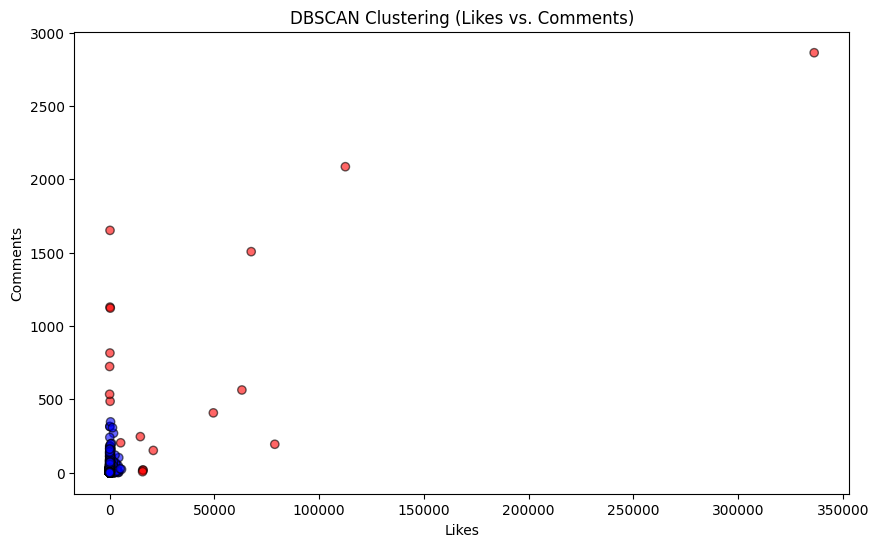

In [32]:
# visualize outliers
plt.figure(figsize=(10, 6))
colors = ['red' if label == -1 else 'blue' for label in imputed_2['labels']]
plt.scatter(imputed_2['likes_count'], imputed_2['comments_count'], c=colors, alpha=0.6, edgecolors='k')
plt.title('DBSCAN Clustering (Likes vs. Comments)')
plt.xlabel('Likes')
plt.ylabel('Comments')
plt.show()

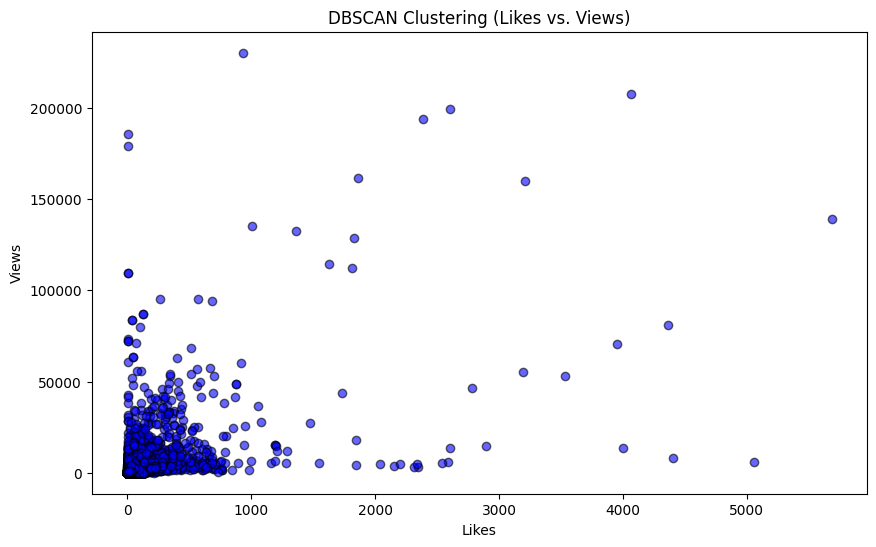

In [33]:
# visualize outliers
plt.figure(figsize=(10, 6))
plt.scatter(imputed_2[imputed_2['labels'] != -1]['likes_count'], imputed_2[imputed_2['labels'] != -1]['video_view_count'], c='blue', alpha=0.6, edgecolors='k')
plt.title('DBSCAN Clustering (Likes vs. Views)')
plt.xlabel('Likes')
plt.ylabel('Views')
plt.show()

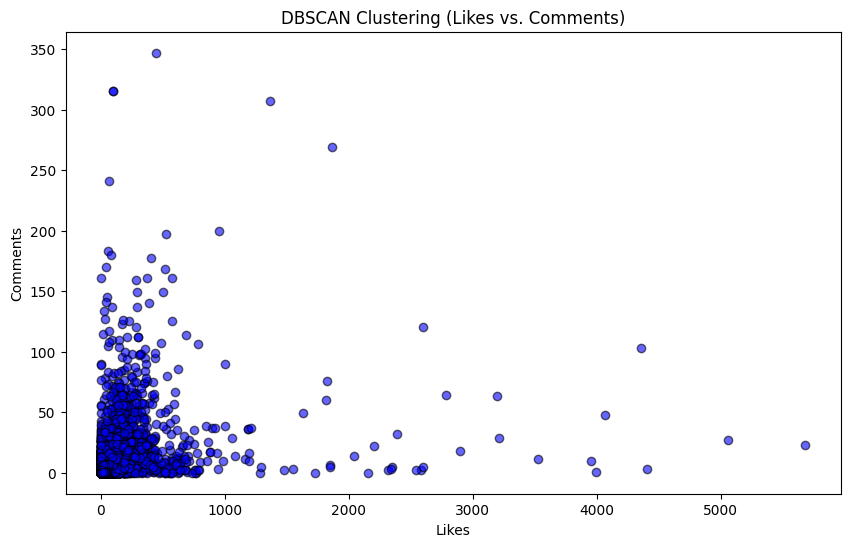

In [34]:
# visualize outliers
plt.figure(figsize=(10, 6))
plt.scatter(imputed_2[imputed_2['labels'] != -1]['likes_count'], imputed_2[imputed_2['labels'] != -1]['comments_count'], c='blue', alpha=0.6, edgecolors='k')
plt.title('DBSCAN Clustering (Likes vs. Comments)')
plt.xlabel('Likes')
plt.ylabel('Comments')
plt.show()

         followers  likes_count  comments_count  video_view_count
count      38166.0      38166.0         38166.0           38166.0
mean   1955.130587    54.477179         3.22127       1694.797333
std    2489.351925  1947.277786       25.681207      75137.504419
min           56.0          0.0             0.0               0.0
25%          646.0          6.0             0.0             125.0
50%         1167.0         16.0             1.0             321.0
75%         2120.0         35.0             3.0             837.0
max        17212.0     336276.0          2863.0        13618871.0


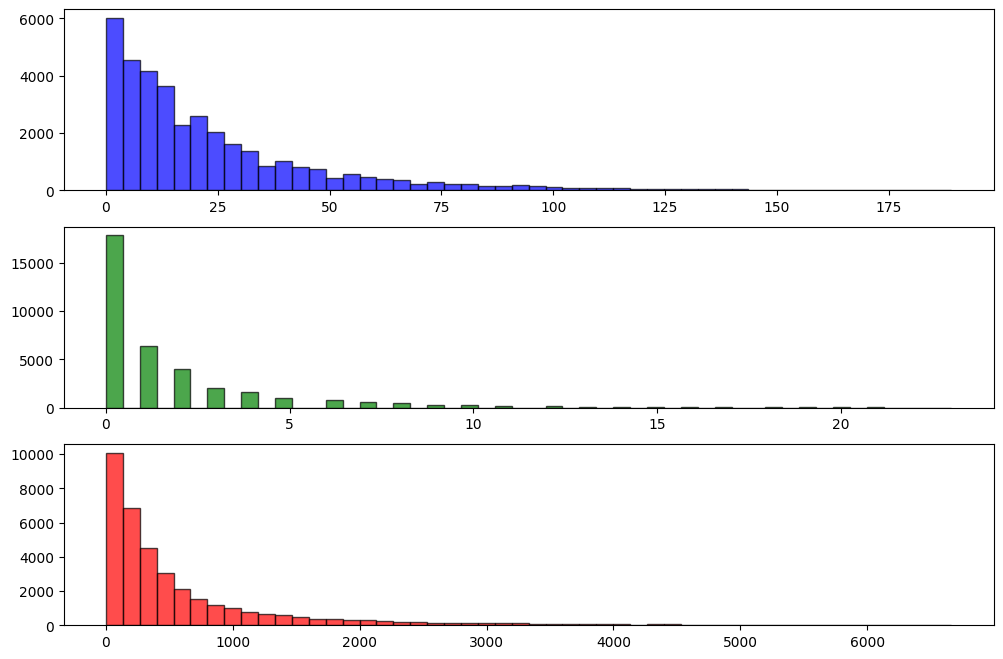

         followers  likes_count  comments_count  video_view_count
count      36643.0      36643.0         36643.0           36643.0
mean   1842.417078    24.477062        1.885026        636.243403
std    2319.248597    27.245519        3.277184        915.061578
min           56.0          0.0             0.0               0.0
25%          634.0          6.0             0.0             119.0
50%         1140.0         15.0             1.0             301.0
75%         2013.0         32.0             2.0             733.0
max        17212.0        189.0            23.0            6662.0


In [44]:
# Remove identified outliers from data
imputed_3 = imputed_2[imputed_2["labels"] != 1]
print(imputed_3[["followers", "likes_count", "comments_count", "video_view_count"]].describe())

# Only 19 removed, but the small number suggests additional methods needed.
# Apply sequential filtering to keep up to the 98th percentile of views,
# 99th percentile of likes, and 99th percentile of comments.
# This essentially removed about 1500 reels. The sequential filtering
# ensures that reels with extreme views are removed, but reels with extreme
# likes and comments are not unfairly over-filtered (high views usually means high engagements).
imputed_3 = imputed_3[imputed_3["video_view_count"] < imputed_3["video_view_count"].quantile(0.98)]
imputed_3 = imputed_3[imputed_3["likes_count"] < imputed_3["likes_count"].quantile(0.99)]
imputed_3 = imputed_3[imputed_3["comments_count"] < imputed_3["comments_count"].quantile(0.99)]

# Plot distributions of engagement metrics
plt.figure(figsize=(12, 8))

# 1. Likes
plt.subplot(3, 1, 1)
plt.hist(
    imputed_3["likes_count"],
    bins=50,
    alpha=0.7,
    color="blue",
    edgecolor="black",
    label="Likes",
)

# 2. Comments
plt.subplot(3, 1, 2)
plt.hist(
    imputed_3["comments_count"],
    bins=50,
    alpha=0.7,
    color="green",
    edgecolor="black",
    label="Comments",
)

# 3. Views
plt.subplot(3, 1, 3)
plt.hist(
    imputed_3["video_view_count"],
    bins=50,
    alpha=0.7,
    color="red",
    edgecolor="black",
    label="Views",
)

plt.show()

print(imputed_3[["followers", "likes_count", "comments_count", "video_view_count"]].describe())

## Aggregation

### Handle the non-independency between users

We aim to address some confounding issues by (1) assuming similar themes in contents, and (2) adjusting engagement metrics (e.g., `likes_count`) based on user-specific metrics (e.g., `followers` or `video_view_count`) to make comparisons across users with different audience sizes meaningful. However, we do not have the data to address other qualitative factors like content quality, visual effects, music vibes, etc, which are typically consistent within a user but vary significantly across users, introducing potential user-level correlations. For example, a single influencer might have 36 popular reels posted all on Monday morning. Even their engagement metrics are adjusted, the numerous observations are deemed as independent records, leading to biases unexpectedly.

To address the potential correlations, we will aggregate reels and average their metrics at User-Day-Time level. The pros are that we reduce the issue of multiple dependent reels within the same day-time slot, and that the dataset is simplified and the model will be straightforward. The cons could be the loss in data granularity and variability (a 50% reduction, in fact, from 49k to 24k), or imbalanced data.

However, since a single user can contribute to multiple day-time bins, user-specific characteristics still influence multiple observations, introducing dependence. Even if we conduct many tests, with each sampling some users in each bin, this is not feasible because we cannot guarantee, or manipulate, that the sampling is picking each user ID at most once during each sampling/test (i.e., if randomly chosen, no control at all; if artificially picked, how do you justify which reel of a user you pick or do you go through all possible permutations?). Therefore, the question now is: are we able to address the user-specific dependency between day-time combinations? Or shall we risk ourselves to accept significance when it is possibly due to repeated measures from the same user?

For now, yes, we want to take the risk to consider qualitative factors as already being reflected in normalized quantitative metrics. Our assumption is that, factors like content quality or video style, are inherently captured by quantitative metrics such as likes, comments, views, and followers. By adjusting these metrics based on user-specific features, we mitigate the impact of varying audience sizes, which indirectly accounting for the qualitative factors that we couldn't measure. In short, we use the normalized engagement metrics as proxies for both quantitative and partial qualitative aspects, thereby reducing but not entirely eliminating user-specific influences. Under this assumption, we must acknowledge that the engagement metrics do not fully capture nuanced qualitative factors like creativity, visual appeal, etc, we are not entirely mitigating the residual correlations.

With this assumption, we have the normality and equal-variance assumptions met, thus we can proceed to ANOVA and Post-Hoc tests if ANOVA is significant.

A side note is that, there are advanced modeling capable for addressing the residual dependencies we mentioned above (e.g., Mixed-Effects Model). We might want to compare their results at the very end.

In [36]:
summarize_dataframe(imputed_3)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency
0,user_id,Int64,0.0,2042,1.215376e+06,1.223152e+06,1.018408e+06,1.445323e+06,426915.0,36
1,reel_id,Int64,0.0,36,1.390175e+01,1.300000e+01,1.000000e+00,3.600000e+01,35.0,1541
2,total_posts,Int64,0.0,1002,6.523030e+02,4.520000e+02,1.200000e+01,3.075500e+04,30743.0,161
3,followers,Int64,0.0,1461,1.842417e+03,1.140000e+03,5.600000e+01,1.721200e+04,17156.0,139
4,followings,Int64,0.0,1398,1.360065e+03,9.890000e+02,0.000000e+00,7.535000e+03,7535.0,123
5,scraped_at,"datetime64[s, UTC]",0.0,2019,NaN,NaN,NaN,NaN,NaN,60
6,comments_count,Int64,0.0,24,1.885026e+00,1.000000e+00,0.000000e+00,2.300000e+01,23.0,17827
7,has_audio,Int64,0.0,2,9.144448e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.0,33508
8,likes_count,Int64,0.0,189,2.447706e+01,1.500000e+01,0.000000e+00,1.890000e+02,189.0,2478
9,created_at,"datetime64[s, UTC]",0.0,35612,NaN,NaN,NaN,NaN,NaN,3


/tmp/ipykernel_2536/4278649262.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated = imputed_3.groupby(


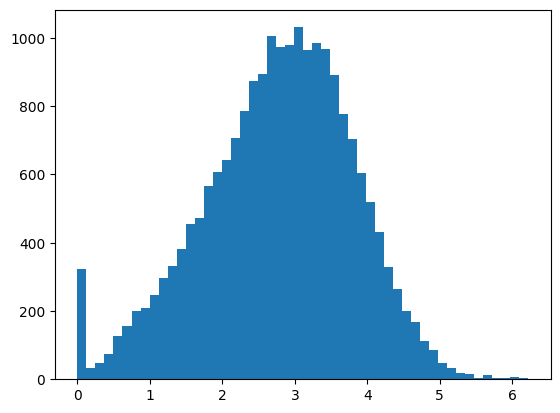

In [37]:
# Aggregate by user-day-time combination
aggregated = imputed_3.groupby(
    by=['user_id', 'day_of_week_pst', 'categorized_created_at_pst'],
).agg(
    {
        'total_posts': 'mean',
        'followers': 'mean',
        'followings': 'mean',
        'likes_count': 'mean',
        'comments_count': 'mean',
        'video_view_count': 'mean',
        'video_duration': 'mean',
    }
).dropna().reset_index()

# Replace 2-col bin with 1-col bin
aggregated['day_time_group'] = aggregated['day_of_week_pst'].astype(str) + '_' + aggregated['categorized_created_at_pst'].astype(str)

# Devise engagement velocity metric
# (For each 100 views, how many likes+comments can it gain?)
# x
# (For each 10000 increase in followers, how many logged views can it gain?)
aggregated['EPF'] = np.log1p(((aggregated['likes_count'] + aggregated['comments_count']) / aggregated['followers']) * 1000)
# aggregated['EPV'] = (aggregated['likes_count'] + aggregated['comments_count']) / (np.log1p(aggregated['video_view_count'])+1) * 100

# Check EPF and EPV
plt.hist((aggregated['EPF']), bins=50)
plt.show()

2.565095870425696e-77


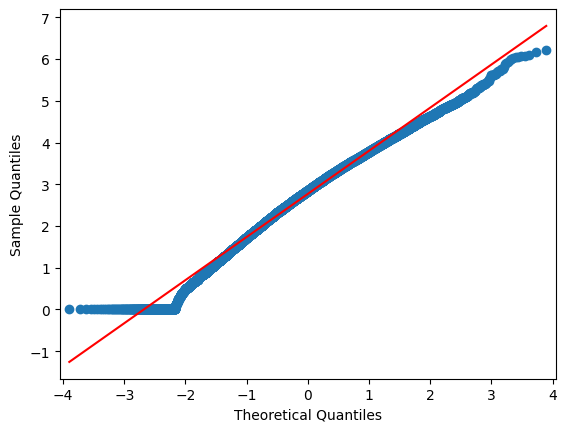

LeveneResult(statistic=np.float64(1.0286978279889758), pvalue=np.float64(0.42265689005242596))
F_onewayResult(statistic=np.float64(6.5386180418294355), pvalue=np.float64(3.258100223894595e-18))


/home/mirrienl/.pyenv/versions/3.12.0/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/tmp/ipykernel_2536/478485306.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_pairs['abs_mean_diff'] = significant_pairs['meandiff'].abs()


,group1,group2,meandiff,p-adj,lower,upper,reject,abs_mean_diff
55,1_Morning,7_Evening,0.3063,0.0000,0.1215,0.4910,True,0.3063
52,1_Morning,6_Evening,0.2909,0.0000,0.1092,0.4725,True,0.2909
142,3_Morning,7_Evening,0.2829,0.0000,0.1016,0.4643,True,0.2829
172,4_Morning,7_Evening,0.2753,0.0000,0.0952,0.4554,True,0.2753
103,2_Morning,7_Evening,0.2690,0.0000,0.0864,0.4516,True,0.2690
139,3_Morning,6_Evening,0.2675,0.0000,0.0893,0.4458,True,0.2675
169,4_Morning,6_Evening,0.2599,0.0000,0.0829,0.4369,True,0.2599
43,1_Morning,3_Evening,0.2553,0.0000,0.0881,0.4226,True,0.2553
100,2_Morning,6_Evening,0.2536,0.0001,0.0741,0.4331,True,0.2536
153,4_Afternoon,7_Evening,0.2390,0.0003,0.0608,0.4173,True,0.2390


In [38]:
# ANOVA
# Normality test
print(stats.normaltest(aggregated['EPF']).pvalue)  # p=2.565e-77: Non Normal!
# But ANOVA is relatively robust to normality violations, particularly if the sample size is large,
# and when the group sizes are equal or similar (n > 30 per group). In addition, due to the CLT,
# with large sample sizes, the sampling distribution of the mean diffs between groups tends to be
# normal, and the impact of non-normality on the Type I error rate is smaller.

import statsmodels.api as sm
sm.qqplot(aggregated['EPF'], line='s')
plt.show()

# Equal-Variance
# This is more critical to ANOVA, where we have p-value of 0.42: Equal Variance
print(stats.levene(*[group['EPF'].values for _, group in aggregated.groupby('day_time_group')]))

# Given the robustness and sample size, as well as the limited addressing of independency issues, we find acceptable to proceed with ANOVA.

# Perform ANOVA
groups = [group['EPF'].values for _, group in aggregated.groupby('day_time_group')]
print(stats.f_oneway(*groups))
# p-value = 3.258e-18: Significant
# There are significant differences in mean EPF across the day-time groups.

from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=aggregated['EPF'],
    groups=aggregated['day_time_group'],
    alpha=0.05,
)
# print(tukey.summary())
# Specific combinations of day and time of day are associated with higher or lower engagement

# Rank pairs
# tukey.plot_simultaneous()
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

significant_pairs = tukey_df[tukey_df['reject'] == True]
# print(significant_pairs)

significant_pairs['abs_mean_diff'] = significant_pairs['meandiff'].abs()
ranked_pairs = significant_pairs.sort_values(by='meandiff', ascending=False)
(ranked_pairs)

In [45]:
# Calculate mean EPF for each day-time group
group_means = aggregated.groupby('day_time_group')['EPF'].mean().reset_index()

# Sort groups by mean EPF in descending order
group_means = group_means.sort_values(by='EPF', ascending=False)
print(group_means)


   day_time_group       EPF
19      7_Evening  2.944172
16      6_Evening  2.928781
7       3_Evening  2.893217
1       1_Evening  2.851113
13      5_Evening  2.849285
18    7_Afternoon  2.838483
4       2_Evening  2.831615
15    6_Afternoon  2.815546
10      4_Evening   2.81342
20      7_Morning  2.761824
17      6_Morning  2.759071
12    5_Afternoon  2.757166
14      5_Morning  2.746291
6     3_Afternoon  2.742774
3     2_Afternoon  2.728799
0     1_Afternoon  2.708483
9     4_Afternoon  2.705132
5       2_Morning  2.675141
11      4_Morning  2.668914
8       3_Morning  2.661248
2       1_Morning  2.637915
